# 0.0 - Imports

In [1]:
import math
import numpy as np
import pandas as pd
import inflection
from sklearn.model_selection import train_test_split
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1 - Helper Functions

In [20]:
def jupyter_settings():

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [21]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 - Load Data

In [2]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# Merging datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store') 

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
891249,35,2,2013-04-23,9468,719,1,1,0,0,d,c,7660.0,10.0,2000.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
26687,1043,3,2015-07-08,8151,1139,1,0,0,0,c,a,420.0,3.0,2006.0,0,NaN,NaN,NaN
190064,515,3,2015-02-11,6833,604,1,0,0,0,d,c,11260.0,NaN,NaN,1,9.0,2011.0,"Feb,May,Aug,Nov"
170224,745,7,2015-03-01,0,0,0,0,0,0,a,a,17650.0,11.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
433631,682,7,2014-06-08,8646,1783,1,0,0,0,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN


## 0.3 - Split Data

In [3]:
# Split dataset into train, test and validation
X_train, X_test, y_train, y_test = train_test_split(df_raw.drop(['Sales'], axis=1), df_raw['Sales'], test_size=0.2, random_state=42)

In [4]:
X_train.sample(5)

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
855127,708,7,2013-05-26,0,0,0,0,0,c,c,11470.0,10.0,2009.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct"
476196,877,4,2014-05-01,0,0,1,a,1,a,c,29190.0,NaN,NaN,0,NaN,NaN,NaN
841395,356,5,2013-06-07,392,1,1,0,0,d,c,8970.0,12.0,2007.0,1,22.0,2012.0,"Feb,May,Aug,Nov"
458760,166,5,2014-05-16,642,1,0,0,0,a,c,100.0,4.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41580,326,3,2015-06-24,318,1,0,0,0,d,a,10070.0,5.0,2015.0,1,31.0,2013.0,"Feb,May,Aug,Nov"


# 1.0 - Data Description

In [5]:
# Creating dataset copy
df1 = X_train.copy()

In [6]:
df1.sample(5)

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
843478,209,3,2013-06-05,620,1,1,0,0,a,c,11680.0,9.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
515464,5,3,2014-03-26,562,1,0,0,0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
445688,474,3,2014-05-28,916,1,0,0,0,c,a,14810.0,NaN,NaN,1,14.0,2011.0,"Mar,Jun,Sept,Dec"
632095,676,4,2013-12-12,1671,1,0,0,0,b,b,1410.0,9.0,2008.0,0,NaN,NaN,NaN
144958,9,1,2015-03-23,659,1,0,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [7]:
type(df1)

pandas.core.frame.DataFrame

## 1.1 - Rename Columns

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
# Putting columns names on list
cols_old = list(df1)

# Function from rename
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Renaming columns
df1.columns = cols_new

# New columns names
df1.columns

Index(['store', 'day_of_week', 'date', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Data Dimension 

In [10]:
# Number of Rows and Columns
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 813767
Number of Columns: 17


## 1.3 - Check Data Types 

In [11]:
# Changing Date Type
df1['date'] = pd.to_datetime(df1['date'])

# Checking types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA's 

In [12]:
# Checking sum of Na's
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2121
competition_open_since_month    258609
competition_open_since_year     258609
promo2                               0
promo2_since_week               406225
promo2_since_year               406225
promo_interval                  406225
dtype: int64

## 1.5 - Fillout NA

In [13]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {
    1: 'Jan', 
    2: 'Feb', 
    3: 'Mar', 
    4: 'Apr', 
    5: 'May', 
    6: 'Jun', 
    7: 'Jul', 
    8: 'Aug', 
    9: 'Sep', 
    10: 'Oct', 
    11: 'Nov', 
    12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.sample(5).transpose()

,216529,454253,372361,970405,829169
store,220,119,482,26,395
day_of_week,7,2,5,1,2
date,2015-01-18 00:00:00,2014-05-20 00:00:00,2014-08-08 00:00:00,2013-02-11 00:00:00,2013-06-18 00:00:00
customers,0,774,858,427,567
open,0,1,1,1,1
promo,0,1,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,a,a,c,d,a
assortment,a,c,a,a,a


## 1.6 - Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int) 

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
type(df1)

pandas.core.frame.DataFrame

## 1.7 - Descriptive Statistics

In [17]:
# Separating numeric from categorical variables
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
712989,0,c,a,0,Sep
247709,0,c,a,0,Dec
940803,0,d,c,0,Mar
619954,0,d,a,0,Dec
828507,0,a,c,"Jan,Apr,Jul,Oct",Jun


### 1.7.1 - Numerical Attributes

In [18]:
# Central tendencies, mean and median
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion, std, min, max, range, skew and kurtosis
d_std = pd.DataFrame(num_attributes.apply(np.std)).T
d_min = pd.DataFrame(num_attributes.apply(min)).T
d_max = pd.DataFrame(num_attributes.apply(max)).T
d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d_min, d_max, d_range, ct_mean, ct_median,d_std, d_skew, d_kurtosis]).T.reset_index()
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std','skew','kurtosis']
m


,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.474664,558.0,321.932550,-0.001268,-1.200817
1,day_of_week,1.0,7.0,6.0,3.997424,4.0,1.997240,0.002528,-1.246598
2,customers,0.0,5494.0,5494.0,633.167813,609.0,464.288732,1.591929,7.016471
3,open,0.0,1.0,1.0,0.830206,1.0,0.375452,-1.758980,1.094014
4,promo,0.0,1.0,1.0,0.381462,0.0,0.485745,0.488068,-1.761794
5,school_holiday,0.0,1.0,1.0,0.178980,0.0,0.383336,1.674880,0.805227
6,competition_distance,20.0,200000.0,199980.0,5932.285863,2330.0,12561.526589,10.244982,147.667350
7,competition_open_since_month,1.0,12.0,11.0,6.788845,7.0,3.310236,-0.042409,-1.231626
8,competition_open_since_year,1900.0,2015.0,115.0,2010.319596,2012.0,5.520914,-7.219063,123.468346
9,promo2,0.0,1.0,1.0,0.500809,1.0,0.499999,-0.003237,-1.999994


/tmp/ipykernel_7582/375460187.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


<Axes: xlabel='Sales', ylabel='Density'>

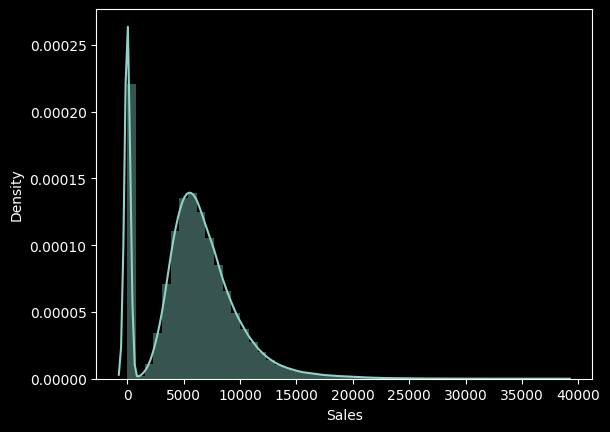

In [19]:
sns.distplot(y_train)

/tmp/ipykernel_7582/3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

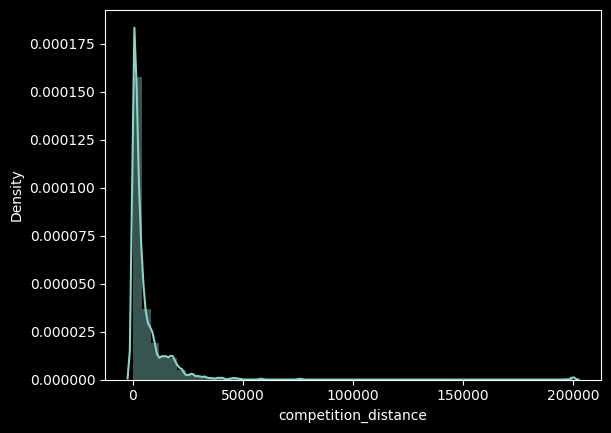

In [20]:
sns.distplot(df1['competition_distance'])

### 1.7.2 - Categorical Attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [22]:
filters = (df1['state_holiday'] != '0') & (df1['sales'] > 0)
aux = df1.loc[filters,:]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

KeyError: 'sales'

## 1.8 - 